## Inverse Problem

This notebook is a simple example of how to solve an inverse problem using at3d. It assumes that we have run the 'SimulateRadiances' notebook and saved the result.

In [1]:
#imports
import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)


### Load Measurements

Here we load the synthetic measurements and also all of the inputs to the solver. We will use several of these inputs to perform 'inverse crimes' whereby we fix some aspects of the problem perfectly as in the forward simulation. When using real world measurements no such short cuts are necessary.

* First, we have to look at the measurements and select a region of interest and define our `rte_grid`. 
* Then we have to model the sensor sub-pixel geometry.
* We need to analyze whether the grid and sensor geometry are consistent. The SpaceCarver is useful for this. If not then we may need to change resolution of `rte_grid` to match the resolution of the measurements etc.
* We need to decide how to represent the surface, which is currently fixed.
* We need to decide how to represent the atmosphere.
    * What scattering species are we modelling? What are their optical models? 
    * Which quantities will be unknowns and which are fixed?
    * What will be the abstract state that we will reconstruct? For this we need to set the mapping between the abstract state and the RTE solver.
* Now that we are organized we need to initialize our state vector of unknowns. The method for this initialization may itself be quite involved as starting nearer the answer is better. This typically goes hand in hand with the selection of any fixed variables.
* Lastly we perform the optimization.

In this tutorial we will reconstruct only the `extinction` and we will use forward quantities from the ground truth synthetic measurements for simplicity.

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesSmallRico.nc')

In [3]:
# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 0*2e-3)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, bcflag=3)
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [4]:

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e8)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
              #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}


In [5]:
# set the generator for the unknown scatterer using ground truth optical properties
# and unknown extinction.
# GridToOpticalProperties holds the fixed optical properties and forms a full set of optical properties
# when it is called with extinction as the argument.

optical_properties = solvers[0.66].medium['cloud'].copy(deep=True)
optical_properties = optical_properties.drop_vars('extinction')

%matplotlib inline
def plot(optimizer):
    py.figure()
    fig, axs = py.subplots(1, 2)
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].extinction.data.ravel(), 
            solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
    axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[1].plot([0,30],[0,30])
    axs[1].axvline(x = np.nanmean(solvers[0.66].medium['cloud'].reff.data.ravel()), color = 'r', linestyle='--')
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.373E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.332  0.411E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.655  0.422E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.889  0.266E+00    32087    40.27  0.157   [Radiance 0.660 micron]
     5  -2.196  0.154E+00    32733    44.26  0.173   [Radiance 0.660 micron]
     6  -2.246  0.902E-01    34625    54.60  0.213   [Radiance 0.660 micron]
     7  -2.372  0.660E-01    37164    67.06  0.262   [Radiance 0.660 micron]
     8  -2.429  0.506E-01    40330    80.45  0.314   [Radiance 0.660 micron]
     9  -2.543  0.423E-01    43701    92.89  0.363   [Radiance 0.660 micron]
    10  -2.599  0.350E-01    48322   106.87  0.417   [Radiance 0.660 micron]
    11  -2.698  0.303E-01    52651   117.77  0.460   [Radiance 0.660 micron]
    12  -2.994  0.300E-01    53098   118.78  0.464   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

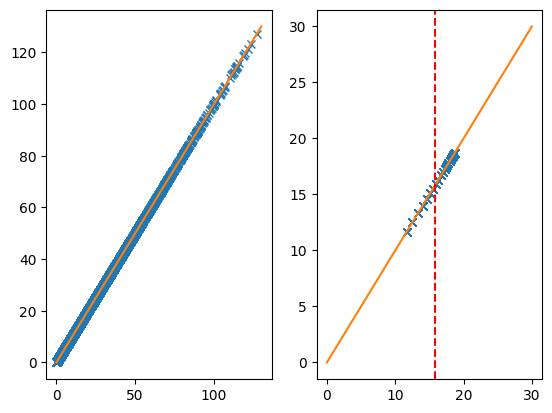

1.9079344934789666e-09
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.373E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.332  0.411E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.655  0.422E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.889  0.266E+00    32087    40.27  0.157   [Radiance 0.660 micron]
     5  -2.196  0.154E+00    32733    44.26  0.173   [Radiance 0.660 micron]
     6  -2.246  0.902E-01    34625    54.60  0.213   [Radiance 0.660 micron]
     7  -2.372  0.660E-01    37164    67.06  0.262   [Radiance 0.660 micron]
     8  -2.429  0.506E-01    40330    80.45  0.314   [Radiance 0.660 micron]


KeyboardInterrupt: 

     9  -2.543  0.423E-01    43701    92.89  0.363   [Radiance 0.660 micron]
    10  -2.599  0.350E-01    48322   106.87  0.417   [Radiance 0.660 micron]
    11  -2.698  0.303E-01    52651   117.77  0.460   [Radiance 0.660 micron]
    12  -2.994  0.300E-01    53098   118.78  0.464   [Radiance 0.660 micron]
    13  -3.241  0.300E-01    53133   118.87  0.464   [Radiance 0.660 micron]
    14  -3.405  0.300E-01    53133   118.87  0.464   [Radiance 0.660 micron]
    15  -3.683  0.300E-01    53133   118.87  0.464   [Radiance 0.660 micron]
    16  -3.810  0.300E-01    53133   118.87  0.464   [Radiance 0.660 micron]
    17  -4.475  0.300E-01    53133   118.87  0.464   [Radiance 0.660 micron]
 ! Iterations:     17     Final Criterion:  0.000033   [Radiance 0.660 micron]


In [6]:
solvers_reconstruct = at3d.containers.SolversDict()
def get_loss(reff_diff):
    # We are using the ground_truth rte_grid.
    grid_to_optical_properties = at3d.medium.GridToOpticalProperties(
        rte_grid,'cloud', 0.66,optical_properties
    )

    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        extinction=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)))
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_extinction = solvers[0.66].medium['cloud'].extinction.data
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['extinction'].state_to_grid.inverse_transform(initial_gridded_extinction)
    x0 = state_gen._unknown_scatterers['cloud'].variables['extinction'].coordinate_transform.inverse_transform(initial_1d_extinction)
    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
        state_gen.project_gradient_to_state,
            parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bounds, max_bounds=max_bounds)
    # solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers[0.66].medium['cloud'].reff.data + reff_diff
    return objective_function(x0)[0]
losses = []
for i in range(10):
    losses.append(get_loss(i))
    plot(None)
    print(losses[i])
    solvers_reconstruct[0.66].medium['cloud'].extinction.data = solvers_reconstruct[0.66].medium['cloud'].extinction.data + 1
py.plot(range(10),losses)
